# Copyright Netherlands eScience Center <br>
** Function     : Compare atmospheric meridional energy transport (MERRA2,ERA-Interim,JRA55)** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : The code aims to compare the atmospheric meridional energy transport
                  calculated from different atmospheric reanalysis datasets. In this,
                  case, this includes MERRA II from NASA, ERA-Interim from ECMWF and
                  JRA55 from JMA.<br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : Atmospheric Meridional Energy Transport   ERA-Interim     MERRA2       JRA55<br>
                  Oceanic Meridional Energy Transport       ORAS4           GLORYS2V3    SODA3<br>
Caveat!!        : Spatial and temporal coverage<br>
                  Atmosphere<br>
                  ERA-Interim   1979 - 2016<br>
                  MERRA2        1980 - 2016<br>
                  JRA55         1979 - 2015<br>
                  Ocean<br>
                  GLORYS2V3     1993 - 2014<br>
                  ORAS4         1958 - 2014<br>
                  SODA3         1980 - 2015<br>
                  NEMO ORCA0083 1979 - 2012<br>
                  The full dataset of ORAS4 is from 1958. However, a quality report from
                  Magdalena from ECMWF indicates the quality of data for the first
                  two decades are very poor. Hence we use the data from 1979. which
                  is the start of satellite era.<br>
                  The full dataset of ORAS4 is from 1958.<br>
                  Data from 20N - 90N are taken into account!<br>

In [1]:
import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import sys
import logging
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
# generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas
from scipy import stats

In [2]:
# specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
#datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
#datapath_MERRA2 = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
datapath_MERRA2 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
#datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
# specify output path for the netCDF4 file
#output_path = '/home/yang/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures'
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures/review'

In [3]:
# index of latitude for insteret
# There is a cut to JRA, too
# from 90N to 20N --> 0:125
# 20N
lat_ERAI_20 = 156
lat_MERRA2_20 = 0
lat_JRA55_20 = 195
# 30N
lat_ERAI_30 = 80
lat_MERRA2_30 = 20
lat_JRA55_30 = 106
# 40N
lat_ERAI_40 = 67
lat_MERRA2_40 = 40
lat_JRA55_40 = 88
# 50N
lat_ERAI_50 = 53
lat_MERRA2_50 = 60
lat_JRA55_50 = 70
# 60N
lat_ERAI_60 = 213
lat_MERRA2_60 = 300
lat_JRA55_60 = 267
# 70N
lat_ERAI_70 = 27
lat_MERRA2_70 = 100
lat_JRA55_70 = 35
# 80N
lat_ERAI_80 = 13
lat_MERRA2_80 = 120
lat_JRA55_80 = 17

# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [20,30,40,50,60,70,80]
lat_interest['ERAI'] = [lat_ERAI_20,lat_ERAI_30,lat_ERAI_40,lat_ERAI_50,lat_ERAI_60,lat_ERAI_70,lat_ERAI_80]
lat_interest['MERRA2'] = [lat_MERRA2_20,lat_MERRA2_30,lat_MERRA2_40,lat_MERRA2_50,lat_MERRA2_60,lat_MERRA2_70,lat_MERRA2_80]
lat_interest['JRA55'] = [lat_JRA55_20,lat_JRA55_30,lat_JRA55_40,lat_JRA55_50,lat_JRA55_60,lat_JRA55_70,lat_JRA55_80]

In [5]:
dataset_ERAI = Dataset(datapath_ERAI + os.sep + 'era_model_subdaily_1979_2017_amet_SH.nc')
dataset_MERRA2 = Dataset(datapath_MERRA2 + os.sep + 'merra_model_subdaily_1980_2017_amet_SH.nc')
dataset_JRA55 = Dataset(datapath_JRA55 + os.sep + 'jra_model_subdaily_1979_2016_amet_SH.nc')

# from 1979 to 2016
# from 20N - 90N
# total energy transport
AMET_E_ERAI = dataset_ERAI.variables['E_int'][:]/1000 # from Tera Watt to Peta Watt
AMET_E_MERRA2 = dataset_MERRA2.variables['E_int'][:]/1000 # from Tera Watt to Peta Watt
AMET_E_JRA55 = dataset_JRA55.variables['E_int'][:]/1000 # from Tera Watt to Peta Watt
# internal energy
AMET_E_cpT_ERAI = dataset_ERAI.variables['cpT_int'][:]/1000
AMET_E_cpT_MERRA2 = dataset_MERRA2.variables['cpT_int'][:]/1000
AMET_E_cpT_JRA55 = dataset_JRA55.variables['cpT_int'][:]/1000
# latent heat
AMET_E_Lvq_ERAI = dataset_ERAI.variables['Lvq_int'][:]/1000
AMET_E_Lvq_MERRA2 = dataset_MERRA2.variables['Lvq_int'][:]/1000
AMET_E_Lvq_JRA55 = dataset_JRA55.variables['Lvq_int'][:]/1000
# geopotential
AMET_E_gz_ERAI = dataset_ERAI.variables['gz_int'][:]/1000
AMET_E_gz_MERRA2 = dataset_MERRA2.variables['gz_int'][:]/1000
AMET_E_gz_JRA55 = dataset_JRA55.variables['gz_int'][:]/1000
# kinetic energy
AMET_E_uv2_ERAI = dataset_ERAI.variables['uv2_int'][:]/1000
AMET_E_uv2_MERRA2 = dataset_MERRA2.variables['uv2_int'][:]/1000
AMET_E_uv2_JRA55 = dataset_JRA55.variables['uv2_int'][:]/1000

year_ERAI = dataset_ERAI.variables['year'][:]        # from 1979 to 2016
year_MERRA2 = dataset_MERRA2.variables['year'][:]    # from 1980 to 2016
year_JRA55 = dataset_JRA55.variables['year'][:]      # from 1979 to 2015

latitude_ERAI = dataset_ERAI.variables['latitude'][:]
latitude_MERRA2 = dataset_MERRA2.variables['latitude'][:]
latitude_JRA55 = dataset_JRA55.variables['latitude'][:]

In [6]:
month_ind = np.arange(12)
# dimension of AMET[year,month]
# total energy transport
AMET_E_ERAI_seansonal_cycle = np.mean(AMET_E_ERAI,axis=0)
AMET_E_ERAI_white = np.zeros(AMET_E_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_ERAI_white[i,j,:] = AMET_E_ERAI[i,j,:] - AMET_E_ERAI_seansonal_cycle[j,:]

AMET_E_MERRA2_seansonal_cycle = np.mean(AMET_E_MERRA2,axis=0)
AMET_E_MERRA2_white = np.zeros(AMET_E_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_MERRA2_white[i,j,:] = AMET_E_MERRA2[i,j,:] - AMET_E_MERRA2_seansonal_cycle[j,:]

AMET_E_JRA55_seansonal_cycle = np.mean(AMET_E_JRA55,axis=0)
AMET_E_JRA55_white = np.zeros(AMET_E_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_JRA55_white[i,j,:] = AMET_E_JRA55[i,j,:] - AMET_E_JRA55_seansonal_cycle[j,:]

# internal energy
AMET_E_cpT_ERAI_seansonal_cycle = np.mean(AMET_E_cpT_ERAI,axis=0)
AMET_E_cpT_ERAI_white = np.zeros(AMET_E_cpT_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_cpT_ERAI_white[i,j,:] = AMET_E_cpT_ERAI[i,j,:] - AMET_E_cpT_ERAI_seansonal_cycle[j,:]

AMET_E_cpT_MERRA2_seansonal_cycle = np.mean(AMET_E_cpT_MERRA2,axis=0)
AMET_E_cpT_MERRA2_white = np.zeros(AMET_E_cpT_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_cpT_MERRA2_white[i,j,:] = AMET_E_cpT_MERRA2[i,j,:] - AMET_E_cpT_MERRA2_seansonal_cycle[j,:]

AMET_E_cpT_JRA55_seansonal_cycle = np.mean(AMET_E_cpT_JRA55,axis=0)
AMET_E_cpT_JRA55_white = np.zeros(AMET_E_cpT_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_cpT_JRA55_white[i,j,:] = AMET_E_cpT_JRA55[i,j,:] - AMET_E_cpT_JRA55_seansonal_cycle[j,:]

# latent heat
AMET_E_Lvq_ERAI_seansonal_cycle = np.mean(AMET_E_Lvq_ERAI,axis=0)
AMET_E_Lvq_ERAI_white = np.zeros(AMET_E_Lvq_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_Lvq_ERAI_white[i,j,:] = AMET_E_Lvq_ERAI[i,j,:] - AMET_E_Lvq_ERAI_seansonal_cycle[j,:]

AMET_E_Lvq_MERRA2_seansonal_cycle = np.mean(AMET_E_Lvq_MERRA2,axis=0)
AMET_E_Lvq_MERRA2_white = np.zeros(AMET_E_Lvq_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_Lvq_MERRA2_white[i,j,:] = AMET_E_Lvq_MERRA2[i,j,:] - AMET_E_Lvq_MERRA2_seansonal_cycle[j,:]

AMET_E_Lvq_JRA55_seansonal_cycle = np.mean(AMET_E_Lvq_JRA55,axis=0)
AMET_E_Lvq_JRA55_white = np.zeros(AMET_E_Lvq_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_Lvq_JRA55_white[i,j,:] = AMET_E_Lvq_JRA55[i,j,:] - AMET_E_Lvq_JRA55_seansonal_cycle[j,:]

# geopotential
AMET_E_gz_ERAI_seansonal_cycle = np.mean(AMET_E_gz_ERAI,axis=0)
AMET_E_gz_ERAI_white = np.zeros(AMET_E_gz_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_gz_ERAI_white[i,j,:] = AMET_E_gz_ERAI[i,j,:] - AMET_E_gz_ERAI_seansonal_cycle[j,:]

AMET_E_gz_MERRA2_seansonal_cycle = np.mean(AMET_E_gz_MERRA2,axis=0)
AMET_E_gz_MERRA2_white = np.zeros(AMET_E_gz_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_gz_MERRA2_white[i,j,:] = AMET_E_gz_MERRA2[i,j,:] - AMET_E_gz_MERRA2_seansonal_cycle[j,:]

AMET_E_gz_JRA55_seansonal_cycle = np.mean(AMET_E_gz_JRA55,axis=0)
AMET_E_gz_JRA55_white = np.zeros(AMET_E_gz_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_gz_JRA55_white[i,j,:] = AMET_E_gz_JRA55[i,j,:] - AMET_E_gz_JRA55_seansonal_cycle[j,:]

# kinetic energy
AMET_E_uv2_ERAI_seansonal_cycle = np.mean(AMET_E_uv2_ERAI,axis=0)
AMET_E_uv2_ERAI_white = np.zeros(AMET_E_uv2_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_uv2_ERAI_white[i,j,:] = AMET_E_uv2_ERAI[i,j,:] - AMET_E_uv2_ERAI_seansonal_cycle[j,:]

AMET_E_uv2_MERRA2_seansonal_cycle = np.mean(AMET_E_uv2_MERRA2,axis=0)
AMET_E_uv2_MERRA2_white = np.zeros(AMET_E_uv2_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_uv2_MERRA2_white[i,j,:] = AMET_E_uv2_MERRA2[i,j,:] - AMET_E_uv2_MERRA2_seansonal_cycle[j,:]

AMET_E_uv2_JRA55_seansonal_cycle = np.mean(AMET_E_uv2_JRA55,axis=0)
AMET_E_uv2_JRA55_white = np.zeros(AMET_E_uv2_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_uv2_JRA55_white[i,j,:] = AMET_E_uv2_JRA55[i,j,:] - AMET_E_uv2_JRA55_seansonal_cycle[j,:]


In [7]:
# take the time series of original signal
# total energy transport
AMET_E_ERAI_series = AMET_E_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_MERRA2_series = AMET_E_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_JRA55_series = AMET_E_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# internal energy
AMET_E_cpT_ERAI_series = AMET_E_cpT_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_cpT_MERRA2_series = AMET_E_cpT_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_cpT_JRA55_series = AMET_E_cpT_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# latent heat
AMET_E_Lvq_ERAI_series = AMET_E_Lvq_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_Lvq_MERRA2_series = AMET_E_Lvq_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_Lvq_JRA55_series = AMET_E_Lvq_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# geopotential
AMET_E_gz_ERAI_series = AMET_E_gz_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_gz_MERRA2_series = AMET_E_gz_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_gz_JRA55_series = AMET_E_gz_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# kinetic energy
AMET_E_uv2_ERAI_series = AMET_E_uv2_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_uv2_MERRA2_series = AMET_E_uv2_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_uv2_JRA55_series = AMET_E_uv2_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))

# take the time series of anomalies
AMET_E_ERAI_white_series = AMET_E_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_MERRA2_white_series = AMET_E_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_JRA55_white_series = AMET_E_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# internal energy
AMET_E_cpT_ERAI_white_series = AMET_E_cpT_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_cpT_MERRA2_white_series = AMET_E_cpT_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_cpT_JRA55_white_series = AMET_E_cpT_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# latent heat
AMET_E_Lvq_ERAI_white_series = AMET_E_Lvq_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_Lvq_MERRA2_white_series = AMET_E_Lvq_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_Lvq_JRA55_white_series = AMET_E_Lvq_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# geopotential
AMET_E_gz_ERAI_white_series = AMET_E_gz_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_gz_MERRA2_white_series = AMET_E_gz_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_gz_JRA55_white_series = AMET_E_gz_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# kinetic energy
AMET_E_uv2_ERAI_white_series = AMET_E_uv2_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_uv2_MERRA2_white_series = AMET_E_uv2_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_uv2_JRA55_white_series = AMET_E_uv2_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))

In [8]:
# running mean is calculated on time series
# define the running window for the running mean
#window = 12 # in month
window = 60 # in month
#window = 120 # in month
# calculate the running mean
# total energy transport
AMET_E_ERAI_running_mean = np.zeros((len(AMET_E_ERAI_series)-window+1,len(latitude_ERAI)),dtype=float)
for i in np.arange(len(AMET_E_ERAI_series)-window+1):
    AMET_E_ERAI_running_mean[i,:] = np.mean(AMET_E_ERAI_series[i:i+window,:],0)

AMET_E_MERRA2_running_mean = np.zeros((len(AMET_E_MERRA2_series)-window+1,len(latitude_MERRA2)),dtype=float)
for i in np.arange(len(AMET_E_MERRA2_series)-window+1):
    AMET_E_MERRA2_running_mean[i,:] = np.mean(AMET_E_MERRA2_series[i:i+window,:],0)

AMET_E_JRA55_running_mean = np.zeros((len(AMET_E_JRA55_series)-window+1,len(latitude_JRA55)),dtype=float)
for i in np.arange(len(AMET_E_JRA55_series)-window+1):
    AMET_E_JRA55_running_mean[i,:] = np.mean(AMET_E_JRA55_series[i:i+window,:],0)

# calculate the running mean of AMET after removing the seasonal cycling
# total energy transport
AMET_E_ERAI_white_running_mean = np.zeros((len(AMET_E_ERAI_white_series)-window+1,len(latitude_ERAI)),dtype=float)
for i in np.arange(len(AMET_E_ERAI_white_series)-window+1):
    AMET_E_ERAI_white_running_mean[i,:] = np.mean(AMET_E_ERAI_white_series[i:i+window,:],0)

AMET_E_MERRA2_white_running_mean = np.zeros((len(AMET_E_MERRA2_white_series)-window+1,len(latitude_MERRA2)),dtype=float)
for i in np.arange(len(AMET_E_MERRA2_white_series)-window+1):
    AMET_E_MERRA2_white_running_mean[i,:] = np.mean(AMET_E_MERRA2_white_series[i:i+window,:],0)

AMET_E_JRA55_white_running_mean = np.zeros((len(AMET_E_JRA55_white_series)-window+1,len(latitude_JRA55)),dtype=float)
for i in np.arange(len(AMET_E_JRA55_white_series)-window+1):
    AMET_E_JRA55_white_running_mean[i,:] = np.mean(AMET_E_JRA55_white_series[i:i+window,:],0)


In [9]:
# calculate the standard deviation of AMET
# ERA-Interim
AMET_E_ERAI_std = np.std(AMET_E_ERAI_series[:,lat_interest['ERAI'][4]])
print ('The standard deviation of AMET from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_std)
# MERRA2
AMET_E_MERRA2_std = np.std(AMET_E_MERRA2_series[:,lat_interest['MERRA2'][4]])
print ('The standard deviation of AMET from MERRA2 is (in peta Watt):')
print (AMET_E_MERRA2_std)
# JRA55
AMET_E_JRA55_std = np.std(AMET_E_JRA55_series[:,lat_interest['JRA55'][4]])
print ('The standard deviation of AMET from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_std)

# calculate the standard deviation of AMET anomaly
# ERA-Interim
AMET_E_ERAI_white_running_mean_std = np.std(AMET_E_ERAI_white_running_mean[:,lat_interest['ERAI'][4]])
print ('The standard deviation of AMET anomaly from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_white_running_mean_std)
# MERRA2
AMET_E_MERRA2_white_running_mean_std = np.std(AMET_E_MERRA2_white_running_mean[:,lat_interest['MERRA2'][4]])
print ('The standard deviation of AMET anomaly from MERRA2 is (in peta Watt):')
print (AMET_E_MERRA2_white_running_mean_std)
# JRA55
AMET_E_JRA55_white_running_mean_std = np.std(AMET_E_JRA55_white_running_mean[:,lat_interest['JRA55'][4]])
print ('The standard deviation of AMET anomaly from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_white_running_mean_std)

The standard deviation of AMET from ERA-Interim is (in peta Watt):
0.9188138847007302
The standard deviation of AMET from MERRA2 is (in peta Watt):
0.9704199276873282
The standard deviation of AMET from JRA55 is (in peta Watt):
0.9071424022737673
The standard deviation of AMET anomaly from ERA-Interim is (in peta Watt):
0.019050179378063872
The standard deviation of AMET anomaly from MERRA2 is (in peta Watt):
0.040617326833408296
The standard deviation of AMET anomaly from JRA55 is (in peta Watt):
0.028108366540892254


In [10]:
# calculate the mean of AMET
# ERA-Interim
AMET_E_ERAI_mean = np.mean(AMET_E_ERAI_series[:,lat_interest['ERAI'][4]])
print ('The mean of AMET from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_mean)
# MERRA2
AMET_E_MERRA2_mean = np.mean(AMET_E_MERRA2_series[:,lat_interest['MERRA2'][4]])
print ('The mean of AMET from MERRA2 is (in peta Watt):')
print (AMET_E_MERRA2_mean)
# JRA55
AMET_E_JRA55_mean = np.mean(AMET_E_JRA55_series[:,lat_interest['JRA55'][4]])
print ('The mean of AMET from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_mean)

# calculate the standard deviation of AMET anomaly
# ERA-Interim
AMET_E_ERAI_white_mean_running_mean = np.mean(AMET_E_ERAI_white_running_mean[:,lat_interest['ERAI'][4]])
print ('The mean of AMET anomaly from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_white_mean_running_mean)
# MERRA2
AMET_E_MERRA2_white_mean_running_mean = np.mean(AMET_E_MERRA2_white_running_mean[:,lat_interest['MERRA2'][4]])
print ('The mean of AMET anomaly from MERRA2 is (in peta Watt):')
print (AMET_E_MERRA2_white_mean_running_mean)
# JRA55
AMET_E_JRA55_white_mean_running_mean = np.mean(AMET_E_JRA55_white_running_mean[:,lat_interest['JRA55'][4]])
print ('The mean of AMET anomaly from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_white_mean_running_mean)

The mean of AMET from ERA-Interim is (in peta Watt):
2.7204688960670405
The mean of AMET from MERRA2 is (in peta Watt):
2.882546408134594
The mean of AMET from JRA55 is (in peta Watt):
2.6761196203399122
The mean of AMET anomaly from ERA-Interim is (in peta Watt):
-0.002776118760656756
The mean of AMET anomaly from MERRA2 is (in peta Watt):
-0.0016523699956089645
The mean of AMET anomaly from JRA55 is (in peta Watt):
-0.0011474115598628268


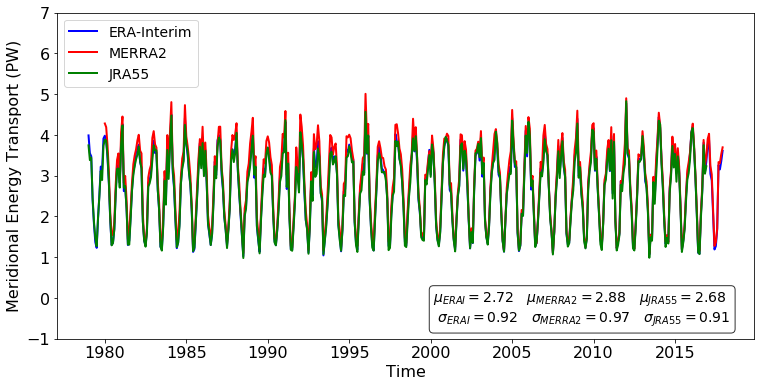

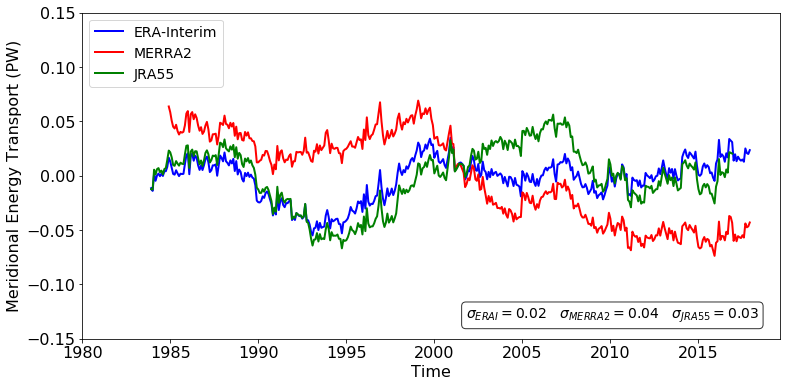

In [11]:
index_1979_2017 = np.arange(1,469,1)
index_1979_2016 = np.arange(1,457,1)
index_1980_2017 = np.arange(13,469,1)
index_year = np.arange(1980,year_ERAI[-1]+1,5)

# plot the AMET with running mean
# total energy transport
text_content = '$\mu_{ERAI}=%.2f$   $\mu_{MERRA2}=%.2f$   $\mu_{JRA55}=%.2f$ \n $\sigma_{ERAI}=%.2f$   $\sigma_{MERRA2}=%.2f$   $\sigma_{JRA55}=%.2f$' \
                % (AMET_E_ERAI_mean, AMET_E_MERRA2_mean, AMET_E_JRA55_mean, AMET_E_ERAI_std, AMET_E_MERRA2_std, AMET_E_JRA55_std)

fig3 = plt.figure()
plt.plot(index_1979_2017,AMET_E_ERAI_series[:,lat_interest['ERAI'][4]],'b-',linewidth=2.0,label='ERA-Interim')
plt.plot(index_1980_2017[:],AMET_E_MERRA2_series[:,lat_interest['MERRA2'][4]],'r-',linewidth=2.0,label='MERRA2')
plt.plot(index_1979_2016,AMET_E_JRA55_series[:,lat_interest['JRA55'][4]],'g-',linewidth=2.0,label='JRA55')
#plt.title('Running Mean of AMET at 60N with a window of 60 months' % (lat_interest_list[i],window))
plt.legend()
fig3.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
#plt.xticks(np.linspace(0, 456, 39), year_ERAI,fontsize=16)
#plt.xticks(rotation=60)
plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
plt.ylabel("Meridional Energy Transport (PW)",fontsize=16)
plt.yticks(np.arange(-1,8,1),fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 14})
# set up the text box
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.54,0.15,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig3.savefig(output_path + os.sep + 'Comp_AMET_E_60N_running_mean_window_60m_comp.png', dpi = 300)
plt.close(fig3)


text_content = '$\sigma_{ERAI}=%.2f$   $\sigma_{MERRA2}=%.2f$   $\sigma_{JRA55}=%.2f$' \
                % (AMET_E_ERAI_white_running_mean_std, AMET_E_MERRA2_white_running_mean_std, AMET_E_JRA55_white_running_mean_std)

# plot the AMET after removing the seasonal cycling with running mean
fig8= plt.figure()
plt.plot(index_1979_2017[window-1:],AMET_E_ERAI_white_running_mean[:,lat_interest['ERAI'][4]],'b-',linewidth=2.0,label='ERA-Interim')
plt.plot(index_1980_2017[window-1:],AMET_E_MERRA2_white_running_mean[:,lat_interest['MERRA2'][4]],'r-',linewidth=2.0,label='MERRA2')
plt.plot(index_1979_2016[window-1:],AMET_E_JRA55_white_running_mean[:,lat_interest['JRA55'][4]],'g-',linewidth=2.0,label='JRA55')
#plt.title('Running Mean of AMET Anomalies at %dN with a window of %d months' % (lat_interest_list[i],window))
fig8.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
#plt.xticks(np.linspace(0, 456, 39), year_ERAI)
plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (PW)",fontsize=16)
plt.yticks(np.arange(-0.15,0.20,0.05),fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 14})
props = dict(boxstyle='round',facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.55,0.10,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig8.savefig(output_path + os.sep + 'Comp_AMET_E_anomaly_60N_running_mean_window_60m_comp.png', dpi = 300)
plt.close(fig8)

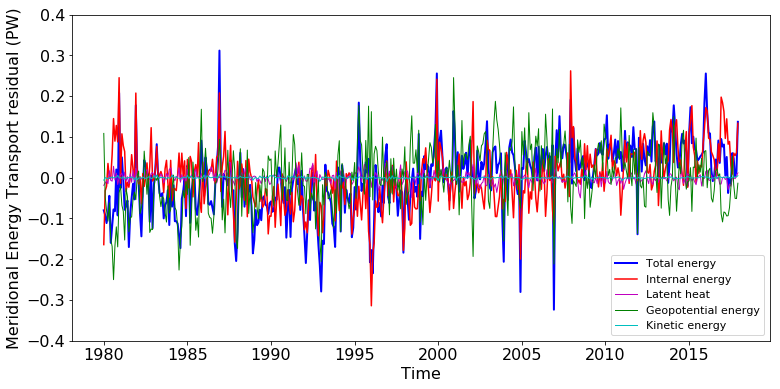

ERA-Interim & MERRA2
cpT
0.5465417329058444
7.118808066577145e-37
***********************
Lvq
0.08735713467955114
0.062338217850765716
***********************
gz
0.5601991404942743
4.940477449874302e-39
***********************
uv2
0.14582539374740083
0.0017954357181170757
***********************


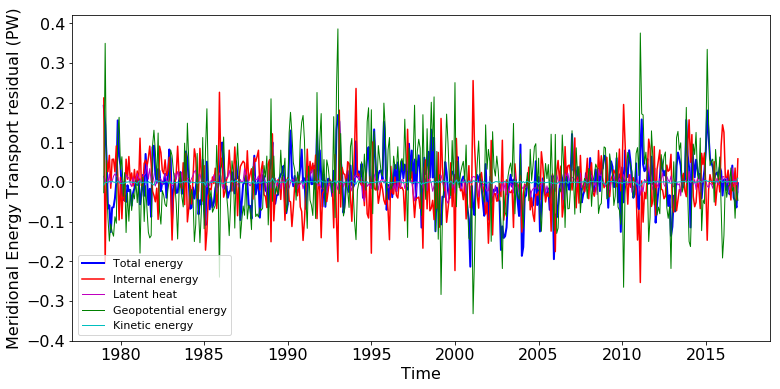

ERA-Interim & JRA55
cpT
-0.0035211468566360505
0.9402266648460866
***********************
Lvq
0.11405458487719004
0.014817414651785233
***********************
gz
0.5985437835243052
1.163390576030014e-45
***********************
uv2
0.07507329580378509
0.10937985561646332
***********************


In [14]:
#calculate the differnce between datasets for each component
#ERA-Interim minus MERRA2
fig14 = plt.figure()
plt.plot(index_1980_2017,AMET_E_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_MERRA2_white_series[:,lat_interest['MERRA2'][4]],'b-',linewidth=2.0,label='Total energy')
plt.plot(index_1980_2017,AMET_E_cpT_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_cpT_MERRA2_white_series[:,lat_interest['MERRA2'][4]],'r-',linewidth=1.5,label='Internal energy')
plt.plot(index_1980_2017,AMET_E_Lvq_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_Lvq_MERRA2_white_series[:,lat_interest['MERRA2'][4]],'m-',linewidth=1.0,label='Latent heat')
plt.plot(index_1980_2017,AMET_E_gz_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_gz_MERRA2_white_series[:,lat_interest['MERRA2'][4]],'g-',linewidth=1.0,label='Geopotential energy')
plt.plot(index_1980_2017,AMET_E_uv2_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_uv2_MERRA2_white_series[:,lat_interest['MERRA2'][4]],'c-',linewidth=1.0,label='Kinetic energy')
#plt.title('Difference between ERA-Interim and MERRA2 anomalies (time series) at 60N' )
plt.legend()
fig14.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(13,len(year_MERRA2)*12+1,60), index_year,fontsize=16)
#plt.xticks(np.linspace(0, 444, 38), year_MERRA2)
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport residual (PW)",fontsize=16)
plt.yticks(np.arange(-0.4,0.5,0.1),fontsize=16)
plt.legend(frameon=True, loc=4, prop={'size': 11})
plt.show()
fig14.savefig(output_path + os.sep +'Comp_AMET_ERAI_minus_MERRA2_anomaly_60N.png', dpi = 300)
plt.close(fig14)

# statistical
slope,_,r_value,p_value,_ = stats.linregress(AMET_E_cpT_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_cpT_MERRA2_white_series[:,lat_interest['MERRA2'][4]],
                                             AMET_E_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_MERRA2_white_series[:,lat_interest['MERRA2'][4]])
print ('ERA-Interim & MERRA2')
print ('cpT')
print (r_value)
print (p_value)
print ('***********************')

slope,_,r_value,p_value,_ = stats.linregress(AMET_E_Lvq_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_Lvq_MERRA2_white_series[:,lat_interest['MERRA2'][4]],
                                             AMET_E_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_MERRA2_white_series[:,lat_interest['MERRA2'][4]])
print ('Lvq')
print (r_value)
print (p_value)
print ('***********************')

slope,_,r_value,p_value,_ = stats.linregress(AMET_E_gz_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_gz_MERRA2_white_series[:,lat_interest['MERRA2'][4]],
                                             AMET_E_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_MERRA2_white_series[:,lat_interest['MERRA2'][4]])
print ('gz')
print (r_value)
print (p_value)
print ('***********************')

slope,_,r_value,p_value,_ = stats.linregress(AMET_E_uv2_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_uv2_MERRA2_white_series[:,lat_interest['MERRA2'][4]],
                                             AMET_E_ERAI_white_series[12:,lat_interest['ERAI'][4]] - AMET_E_MERRA2_white_series[:,lat_interest['MERRA2'][4]])
print ('uv2')
print (r_value)
print (p_value)
print ('***********************')


#ERA-Interim minus JRA55
fig16 = plt.figure()
plt.plot(index_1979_2016,AMET_E_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_JRA55_white_series[:,lat_interest['JRA55'][4]],'b-',linewidth=2.0,label='Total energy')
plt.plot(index_1979_2016,AMET_E_cpT_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_cpT_JRA55_white_series[:,lat_interest['JRA55'][4]],'r-',linewidth=1.5,label='Internal energy')
plt.plot(index_1979_2016,AMET_E_Lvq_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_Lvq_JRA55_white_series[:,lat_interest['JRA55'][4]],'m-',linewidth=1.0,label='Latent heat')
plt.plot(index_1979_2016,AMET_E_gz_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_gz_JRA55_white_series[:,lat_interest['JRA55'][4]],'g-',linewidth=1.0,label='Geopotential energy')
plt.plot(index_1979_2016,AMET_E_uv2_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_uv2_JRA55_white_series[:,lat_interest['JRA55'][4]],'c-',linewidth=1.0,label='Kinetic energy')
#plt.title('Difference between ERA-Interim and JRA55 anomalies (time series) at %dN' % (lat_interest_list[i]))
plt.legend()
fig16.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
plt.yticks(np.arange(-0.4,0.5,0.1),fontsize=16)
plt.ylabel("Meridional Energy Transport residual (PW)",fontsize=16)
plt.legend(frameon=True, loc=3, prop={'size': 11})
plt.show()
fig16.savefig(output_path + os.sep + 'Comp_AMET_ERAI_minus_JRA55_anomaly_60N.png', dpi = 300)
plt.close(fig16)

# statistical
slope,_,r_value,p_value,_ = stats.linregress(AMET_E_cpT_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_cpT_JRA55_white_series[:,lat_interest['JRA55'][4]],
                                             AMET_E_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_JRA55_white_series[:,lat_interest['JRA55'][4]])
print ('ERA-Interim & JRA55')
print ('cpT')
print (r_value)
print (p_value)
print ('***********************')

slope,_,r_value,p_value,_ = stats.linregress(AMET_E_Lvq_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_Lvq_JRA55_white_series[:,lat_interest['JRA55'][4]],
                                             AMET_E_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_JRA55_white_series[:,lat_interest['JRA55'][4]])
print ('Lvq')
print (r_value)
print (p_value)
print ('***********************')

slope,_,r_value,p_value,_ = stats.linregress(AMET_E_gz_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_gz_JRA55_white_series[:,lat_interest['JRA55'][4]],
                                             AMET_E_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_JRA55_white_series[:,lat_interest['JRA55'][4]])
print ('gz')
print (r_value)
print (p_value)
print ('***********************')

slope,_,r_value,p_value,_ = stats.linregress(AMET_E_uv2_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_uv2_JRA55_white_series[:,lat_interest['JRA55'][4]],
                                             AMET_E_ERAI_white_series[:-12,lat_interest['ERAI'][4]] - AMET_E_JRA55_white_series[:,lat_interest['JRA55'][4]])
print ('uv2')
print (r_value)
print (p_value)
print ('***********************')
